In [1]:
import torch
import numpy as np
import random
from IPython import display
from matplotlib import pyplot as plt
import torch.utils.data as Data
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  #防止jupyter崩溃

In [2]:
#自定义数据---训练集
num_inputs = 200
#1类
x1 = torch.normal(2,1,(10000, num_inputs))
y1 = torch.ones(10000,1) # 标签1 
x1_train = x1[:7000]
x1_test = x1[7000:]
#0类
x2 = torch.normal(-2,1,(10000, num_inputs))
y2 = torch.zeros(10000,1) # 标签0
x2_train = x2[:7000]
x2_test = x2[7000:]
#合并训练集
# 注意 x, y 数据的数据形式一定要像下面一样 (torch.cat 是合并数据)---按行合并
trainfeatures = torch.cat((x1_train,x2_train), 0).type(torch.FloatTensor)
trainlabels = torch.cat((y1[:7000], y2[:7000]), 0).type(torch.FloatTensor)
#合并测试集
# 注意 x, y 数据的数据形式一定要像下面一样 (torch.cat 是合并数据)---按行合并
testfeatures = torch.cat((x1_test,x2_test), 0).type(torch.FloatTensor)
testlabels = torch.cat((y1[7000:], y2[7000:]), 0).type(torch.FloatTensor)
print(trainfeatures.shape,trainlabels.shape,testfeatures.shape,testlabels.shape)

torch.Size([14000, 200]) torch.Size([14000, 1]) torch.Size([6000, 200]) torch.Size([6000, 1])


In [3]:
#读取数据
batch_size = 50
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(trainfeatures, trainlabels)
# 把 dataset 放入 DataLoader
train_iter = Data.DataLoader(
    dataset=dataset, # torch TensorDataset format
    batch_size=batch_size, # mini batch size
    shuffle=True, # 是否打乱数据 (训练集一般需要进行打乱)
    num_workers=0, # 多线程来读数据， 注意在Windows下需要设置为0
)
# 将测试数据的特征和标签组合
dataset = Data.TensorDataset(testfeatures, testlabels)
# 把 dataset 放入 DataLoader
test_iter = Data.DataLoader(
    dataset=dataset, # torch TensorDataset format
    batch_size=batch_size, # mini batch size
    shuffle=True, # 是否打乱数据
    num_workers=0, # 多线程来读数据， 注意在Windows下需要设置为0
)

In [4]:
#初始化参数
num_hiddens,num_outputs = 256,1

W1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens,num_inputs)), dtype=torch.float32)
b1 = torch.zeros(1, dtype=torch.float32)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_outputs,num_hiddens)), dtype=torch.float32)
b2 = torch.zeros(1, dtype=torch.float32)
params =[W1,b1,W2,b2]
for param in params:
    param.requires_grad_(requires_grad=True)

In [5]:
def relu(x):
    x = torch.max(input=x,other=torch.tensor(0.0))
    return x

In [6]:
#定义模型
def net(X):
    X = X.view((-1,num_inputs))
    H = relu(torch.matmul(X,W1.t())+b1)
    return torch.matmul(H,W2.t())+b2

In [7]:
#定义交叉熵损失函数
loss = torch.nn.BCEWithLogitsLoss()

In [8]:
#定义随机梯度下降法
def SGD(paras,lr,batch_size):
    for param in params:
        param.data -= lr * param.grad/batch_size

In [9]:
#定义模型训练函数
def train(net,train_iter,test_iter,loss,num_epochs,batch_size,params=None,lr=None,optimizer=None):
    train_ls = []
    test_ls = []
    for epoch in range(num_epochs): # 训练模型一共需要num_epochs个迭代周期
        train_l_sum, train_acc_num,n = 0.0,0.0,0
        # 在每一个迭代周期中，会使用训练数据集中所有样本一次
        for X, y in train_iter: # x和y分别是小批量样本的特征和标签
            y_hat = net(X)
            l = loss(y_hat, y.view(-1,1)).sum() # l是有关小批量X和y的损失
            #梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward() # 小批量的损失对模型参数求梯度
            if optimizer is None:
                SGD(params,lr,batch_size)
            else:
                optimizer.step()
            #计算每个epoch的loss
            train_l_sum += l.item()*y.shape[0]
            #train_acc_num += (y_hat.argmax(dim=1)==y).sum().item()
            n+= y.shape[0]
        test_labels = testlabels.view(-1,1)
        train_ls.append(train_l_sum/n)
        test_ls.append(loss(net(testfeatures),test_labels).sum().item())
        print('epoch %d, train_loss %.6f,test_loss %.6f'%(epoch+1, train_ls[epoch],test_ls[epoch]))
    return train_ls,test_ls

In [10]:
lr = 0.01
num_epochs = 50
train_loss,test_loss = train(net,train_iter,test_iter,loss,num_epochs,batch_size,params,lr)

epoch 1, train_loss 0.634805,test_loss 0.562258
epoch 2, train_loss 0.486398,test_loss 0.408634
epoch 3, train_loss 0.335810,test_loss 0.268100
epoch 4, train_loss 0.215928,test_loss 0.170963
epoch 5, train_loss 0.139644,test_loss 0.113196
epoch 6, train_loss 0.094985,test_loss 0.079433
epoch 7, train_loss 0.068437,test_loss 0.058848
epoch 8, train_loss 0.051832,test_loss 0.045579
epoch 9, train_loss 0.040859,test_loss 0.036568
epoch 10, train_loss 0.033244,test_loss 0.030169
epoch 11, train_loss 0.027737,test_loss 0.025451
epoch 12, train_loss 0.023615,test_loss 0.021864
epoch 13, train_loss 0.020440,test_loss 0.019065
epoch 14, train_loss 0.017936,test_loss 0.016832
epoch 15, train_loss 0.015919,test_loss 0.015018
epoch 16, train_loss 0.014268,test_loss 0.013519
epoch 17, train_loss 0.012894,test_loss 0.012265
epoch 18, train_loss 0.011738,test_loss 0.011202
epoch 19, train_loss 0.010753,test_loss 0.010291
epoch 20, train_loss 0.009905,test_loss 0.009504
epoch 21, train_loss 0.009169

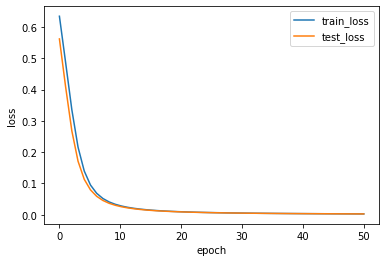

In [11]:
x = np.linspace(0,len(train_loss),len(train_loss))
plt.plot(x,train_loss,label="train_loss",linewidth=1.5)
plt.plot(x,test_loss,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()